In [1]:
#!pip install pandas -U
from data_science_tools.datasets import GeomLabelSet
from data_science_tools.datasets import MetaData
from data_science_tools.datasets.origins import CustomOrigin
from data_science_tools.geometry.wkb_utils import shapely_to_wkb, wkb_to_shapely
from data_science_tools.tile_servers import ShowerV2
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely.geometry
import warnings

In [2]:
gdf = gpd.read_file("raw_data.gpkg")

<Axes: >

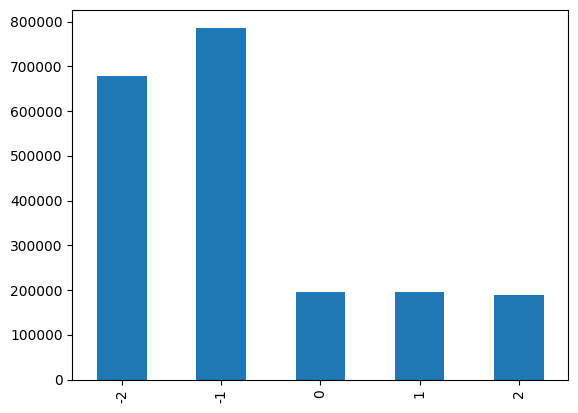

In [3]:
gdf['rcr'].value_counts().loc[['-2', '-1', '0', '1', '2']].plot.bar()

In [4]:
# Let's build the dataset
gdf.head(1)

,rcr,lon,lat,geometry
0,-2,-116.907815,32.743351,"POLYGON ((-116.90794 32.74339, -116.90794 32.7..."


In [5]:
sv2 = ShowerV2()
imagery_layer = "nearmap_20220801"  # shower v2 layer

In [6]:
gdf['group'] = [1] * 500000 + [2] * 500000 + [3] * 500000 + [4] * (gdf.shape[0] - 1500000)

In [12]:
gdf['group'].value_counts()

4    697945
1    500000
2    500000
3    500000
Name: group, dtype: int64

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i, grp_df in gdf.groupby("group"):
        df_with_surveys = sv2.get_best_surveys_of_layer_geom(
            imagery_layer, geom=grp_df["geometry"].iloc[:100], zp=20, x_padding=1, y_padding=1
        )

        grp_df['geom_wkb'] = grp_df['geometry'].apply(shapely_to_wkb)
        df_with_surveys['geom_wkb'] = df_with_surveys['geometry'].apply(shapely_to_wkb)

        merged = grp_df.merge(df_with_surveys[['imagery_source', 'imagery_date', 'geometry', 'geom_id', 'geom_wkb']], on='geom_wkb')
        merged.head(2)
        
        # grp_df.iloc[:100].to_file(f"grp_{i}.gpkg", driver='GPKG')
        # df_with_surveys.to_hdf(f"surveys_{i}.hdf", "surveys")

        break

Getting surveys from Blanket :

[*********100.0%*************]  100 / 100 metatile in 1.2 s (0:00:00 to go)


In [4]:
df_with_surveys = pd.concat([pd.read_hdf(f"survey{i}.hdf") for i in range(1, 5)]).reset_index(drop=True)

In [5]:
df_with_surveys.shape

(2197943, 18)

In [7]:
df_with_surveys.head(2)

,id,provider_survey_id,capture_date,provider_online_date,cape_capture_date,cape_online_date,org_id,org_name,datatype_name,additional_datatype_names,provider_name,unique_survey_id,requested_datatype_name,imagery_source,imagery_date,geom_id,geometry,has_oblique
0,1631037,62703536-c65d-11ec-872f-17927c70f651,2022-04-23 00:00:00+00:00,2022-04-27 19:08:12+00:00,2022-04-28 06:02:09.478305+00:00,2022-04-28 06:02:09.832110+00:00,None,None,nearmap_vertical_jpg,[],nearmap,62703536-c65d-11ec-872f-17927c70f651,nearmap_vertical_jpg,sv2:nearmap_vertical_jpg:62703536-c65d-11ec-87...,2022-04-23 00:00:00+00:00,0,POLYGON ((-116.9079369306564 32.74339015941727...,False
1,1632268,f50fad96-f307-11ec-b419-775e2f160185,2022-06-17 00:00:00+00:00,2022-06-23 15:20:04+00:00,2022-06-24 06:03:21.100204+00:00,2022-06-24 06:03:21.449205+00:00,None,None,nearmap_vertical_jpg,[],nearmap,f50fad96-f307-11ec-b419-775e2f160185,nearmap_vertical_jpg,sv2:nearmap_vertical_jpg:f50fad96-f307-11ec-b4...,2022-06-17 00:00:00+00:00,1,"POLYGON ((-118.010234311223 33.75895535233063,...",False


In [8]:
df_with_surveys.to_hdf("with_surveys.hdf", key="surveys")

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->Index(['provider_survey_id', 'org_id', 'org_name', 'datatype_name',
       'additional_datatype_names', 'provider_name', 'unique_survey_id',
       'requested_datatype_name', 'imagery_source', 'geometry'],
      dtype='object')]

  pytables.to_hdf(


In [19]:
df_with_surveys = pd.read_hdf("with_surveys.hdf")

In [27]:
gdf.head(2)

,rcr,lon,lat,geometry,group
0,-2,-116.907815,32.743351,"POLYGON ((-116.90794 32.74339, -116.90794 32.7...",1
1,-2,-118.010182,33.758540,"POLYGON ((-118.01023 33.75896, -118.01029 33.7...",1


In [22]:
df_with_surveys.head(2)

,id,provider_survey_id,capture_date,provider_online_date,cape_capture_date,cape_online_date,org_id,org_name,datatype_name,additional_datatype_names,provider_name,unique_survey_id,requested_datatype_name,imagery_source,imagery_date,geom_id,geometry,has_oblique
0,1631037,62703536-c65d-11ec-872f-17927c70f651,2022-04-23 00:00:00+00:00,2022-04-27 19:08:12+00:00,2022-04-28 06:02:09.478305+00:00,2022-04-28 06:02:09.832110+00:00,None,None,nearmap_vertical_jpg,[],nearmap,62703536-c65d-11ec-872f-17927c70f651,nearmap_vertical_jpg,sv2:nearmap_vertical_jpg:62703536-c65d-11ec-87...,2022-04-23 00:00:00+00:00,0,POLYGON ((-116.9079369306564 32.74339015941727...,False
1,1632268,f50fad96-f307-11ec-b419-775e2f160185,2022-06-17 00:00:00+00:00,2022-06-23 15:20:04+00:00,2022-06-24 06:03:21.100204+00:00,2022-06-24 06:03:21.449205+00:00,None,None,nearmap_vertical_jpg,[],nearmap,f50fad96-f307-11ec-b419-775e2f160185,nearmap_vertical_jpg,sv2:nearmap_vertical_jpg:f50fad96-f307-11ec-b4...,2022-06-17 00:00:00+00:00,1,"POLYGON ((-118.010234311223 33.75895535233063,...",False


In [23]:
df.shape

(2197945, 3)

In [29]:
gdf['geom_wkb'] = gdf['geometry'].apply(shapely_to_wkb)

In [25]:
df_with_surveys['geom_wkb'] = df_with_surveys['geometry'].apply(shapely_to_wkb)

In [30]:
merged = gdf.merge(df_with_surveys[['imagery_source', 'imagery_date', 'geometry', 'geom_id', 'geom_wkb']], on='geom_wkb')
merged.head(2)

,rcr,lon,lat,geometry_x,group,geom_wkb,imagery_source,imagery_date,geometry_y,geom_id
0,-2,-116.907815,32.743351,"POLYGON ((-116.90794 32.74339, -116.90794 32.7...",1,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00%\x00\x0...,sv2:nearmap_vertical_jpg:62703536-c65d-11ec-87...,2022-04-23 00:00:00+00:00,POLYGON ((-116.9079369306564 32.74339015941727...,0
1,-2,-118.010182,33.758540,"POLYGON ((-118.01023 33.75896, -118.01029 33.7...",1,b'\x01\x03\x00\x00\x00\x04\x00\x00\x00\xa0\x00...,sv2:nearmap_vertical_jpg:f50fad96-f307-11ec-b4...,2022-06-17 00:00:00+00:00,"POLYGON ((-118.010234311223 33.75895535233063,...",1


In [31]:
merged['geometry'] = merged['geom_wkb']

In [35]:
# Go from the Vinyasa/flow taxonomy -2, -1, 0, 1, 2, unknown to the
# product taxonomy severe, poor, fair, good, excellent, unknown
merged['geometry_labels'] = merged['rcr'].replace(
    {
        '-2': 'severe',
        '-1': 'poor',
        '0': 'fair',
        '1': 'good',
        '2': 'excellent',
        'unknown': 'unknown'
    }
)
merged['geometry_labels'].value_counts()

poor         787001
severe       678294
good         196194
fair         194918
excellent    190006
unknown      151530
Name: geometry_labels, dtype: int64

In [36]:
merged['geometry_id'] = merged['geom_id']

In [37]:
col_to_keep = [
    'geometry_labels',
    'imagery_source',
    'imagery_date',
    'geometry_id',
    'geometry'
]

merged = merged[col_to_keep]

In [38]:
merged.shape

(2197943, 5)

In [39]:
del df
del df_with_surveys

In [40]:
import gc
gc.collect()

5120

In [41]:
merged.drop_duplicates().shape

(2197943, 5)

In [42]:
md = MetaData(
    author="Giacomo Vianello",
    project="dinov2",
    description="A lot of roofs stratified by RCR value (with -2 being twice as prevalent). Pseudo labels from RCRv4 from project explorer v3",
    ticket_number="ML-000",
    scope="train",
    geometry_taxonomy="roof @ 1.0: ground_truth",
    label_taxonomy="roof_condition_rating @ 4.0: product # roof_condition_rating",
    origin=CustomOrigin("https://capeanalytics.atlassian.net/wiki/spaces/CVML/pages/3035595064/Stratified+RCR+dataset")
)

In [43]:
gls = GeomLabelSet.from_pandas(md, merged[col_to_keep])

In [44]:
gls.upload_to_data_repo("dinov2/rcr_lots_of_severe_2M", overwrite=True)

20/09/2023 07:25:35 INFO data_science_tools.data_sources.cloud_storage: Cloud file gs://cape-ml-mnemonics/v3/ground_truth/dinov2/rcr_lots_of_severe_2M.json has been deleted.
20/09/2023 07:25:35 INFO data_science_tools.data_sources.cloud_storage: Cloud file gs://cape-ml-mnemonics/v3/ground_truth/dinov2/rcr_lots_of_severe_2M.parquet has been deleted.
20/09/2023 07:25:43 INFO data_science_tools.data_sources.cloud_storage: Local file /tmp/tmpkmuvnq3r/rcr_lots_of_severe_2M.json has been uploaded into gs://cape-ml-mnemonics/v3/ground_truth/dinov2/rcr_lots_of_severe_2M.json.
20/09/2023 07:25:52 INFO data_science_tools.data_sources.cloud_storage: Local file /tmp/tmpkmuvnq3r/rcr_lots_of_severe_2M.parquet has been uploaded into gs://cape-ml-mnemonics/v3/ground_truth/dinov2/rcr_lots_of_severe_2M.parquet.


('gs://cape-ml-mnemonics/v3/ground_truth/dinov2/rcr_lots_of_severe_2M.json',
 'gs://cape-ml-mnemonics/v3/ground_truth/dinov2/rcr_lots_of_severe_2M.parquet')